# Finetune a CellPose with DINOV2 backbone model from scratch

This example shows how to use `cellseg_models.pytorch` for finetuning a [CellPose](https://www.nature.com/articles/s41592-020-01018-x) model with [`DINOv2`-backbone](https://arxiv.org/abs/2304.07193) (with registers) for instance segmentation. We will utilize [lightning](https://lightning.ai/docs/pytorch/latest/) to train the model. 

In [1]:
# !pip install cellseg-models-pytorch
# !pip install lightning

In [2]:
import torch
import lightning
import cellseg_models_pytorch
from platform import python_version

print("torch version:", torch.__version__)
print("lightning version:", lightning.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.1.1+cu121
lightning version: 2.3.1
cellseg_models_pytorch version: 0.1.25
python version: 3.10.12


## Download data

First, we will download some nuclei segmentation data. We will use the [Pannuke](https://jgamper.github.io/PanNukeDataset/) dataset by Gamper et al. The Pannuke dataset is split into three folds. We will use the first and second fold as training data and the third as validation data.

Since we will finetune the [CellPose](https://www.nature.com/articles/s41592-020-01018-x) model, we need to define the right nuclei instance transformations for training time. For `Cellpose`, we define `"cellpose"` transformation. The `"cellpose"` transforms the labelled instance masks into horizontal and vertical image gradient flows of the nuclei. The model has an output head that regresses these types of masks which will be used for post-processing the nuclei.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"percentile"` normalization for the input images.

**NOTE** We need to add also the `resize` transformation here, since `DINOv2` was trained with a patch size of 14. pannuke-images are 256x256 which is not a multiple of 14, thus, we resize the images to to the same size Dinov2 was trained, that is, 518x518.

In [3]:
from pathlib import Path
from cellseg_models_pytorch.datamodules import PannukeDataModule

fold_split = {"fold1": "train", "fold2": "train", "fold3": "valid"}

# NOTE The 'pannuke' directory has to already exist for this to work.
# You can create one in your home folder or just modify the path to your liking,
# The pannuke dataset will be downloaded there.
save_dir = Path.home() / "pannuke_dataset"
pannuke_module = PannukeDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["cellpose"],
    img_transforms=["blur", "hue_sat", "resize"],
    normalization="percentile",
    batch_size=8,
    num_workers=8,
    height=518,
    width=518,
)

# NOTE: this will take a while to run
pannuke_module.prepare_data()  # download and process the pannuke data

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


## Visualize training samples

Here we plot the training image patches with their corresponding instance and type label masks to get a glimpse of what kind of training data Pannuke has.

We also visualize the `cellpose` transformation applied to the instance masks. The `CellPose`-model is going to regress this transformed auxilliary output which is later used in post-processing to separate overlapping and clumped nuclei.

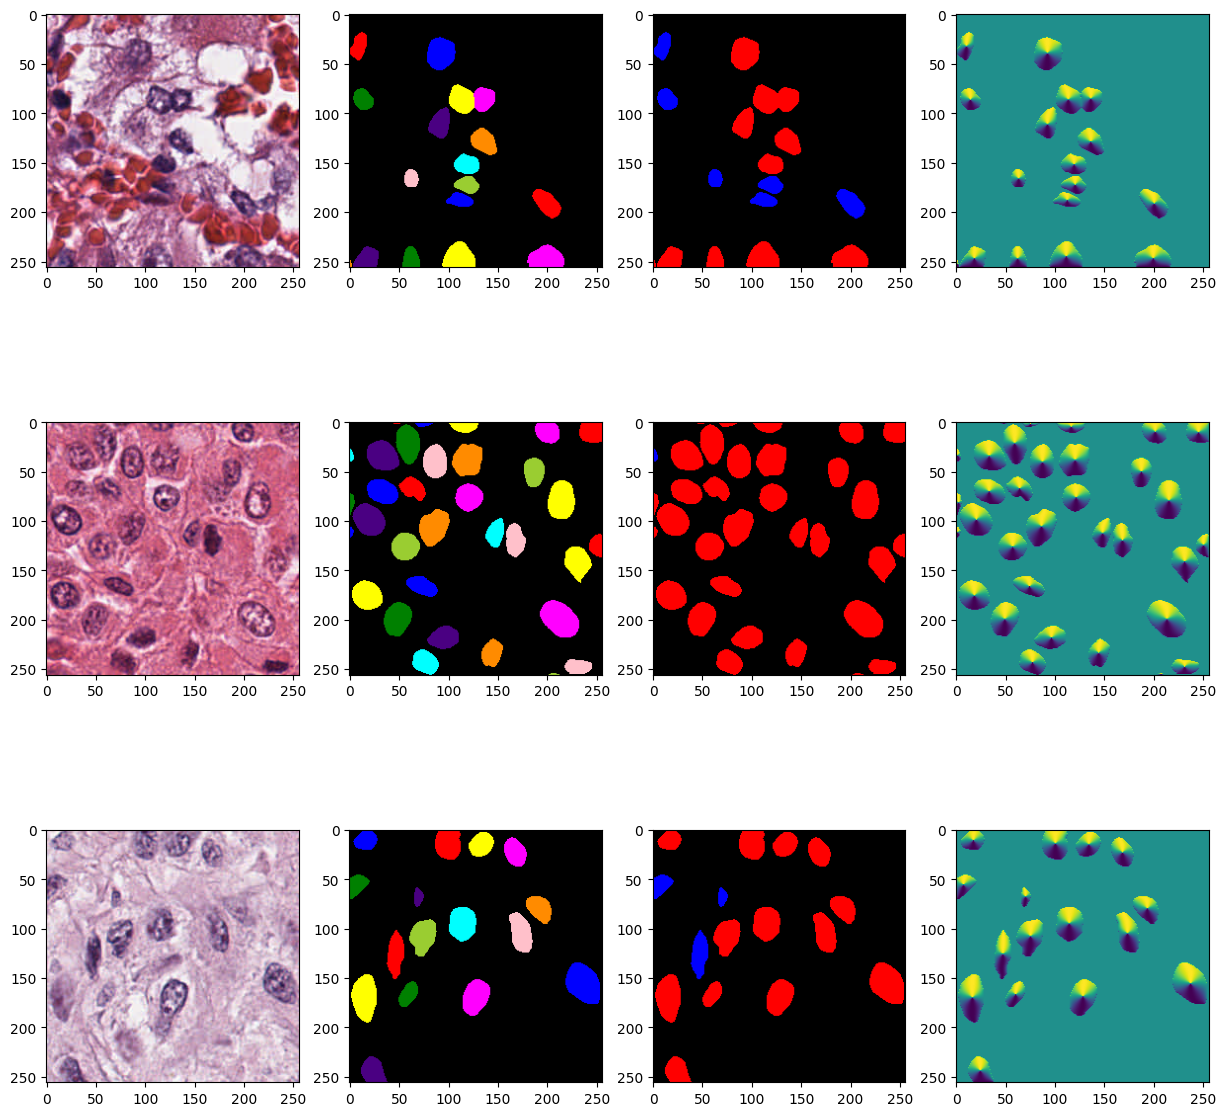

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# filehandler contains methods to read and write images and masks
from cellseg_models_pytorch.utils import FileHandler
from cellseg_models_pytorch.transforms.functional import gen_flow_maps

img_dir = save_dir / "train" / "images"
mask_dir = save_dir / "train" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)

im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
mask1 = FileHandler.read_mat(masks[ixs[0]], return_all=True)
mask2 = FileHandler.read_mat(masks[ixs[1]], return_all=True)
mask3 = FileHandler.read_mat(masks[ixs[2]], return_all=True)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(gen_flow_maps(mask1["inst_map"])[0])
ax[4].imshow(im2)
ax[5].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[6].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[7].imshow(gen_flow_maps(mask2["inst_map"])[0])
ax[8].imshow(im3)
ax[9].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[10].imshow(label2rgb(mask3["type_map"], bg_label=0))
ax[11].imshow(gen_flow_maps(mask3["inst_map"])[0])

## Finetuning with `lightning`. Defining a `pl.LightningModule`.

Next, we will define a `SegmentationExperiment`. It is a `pl.LightningModule` wrapper that encapsulates everything needed for finetuning the model. It is a nice way to wrap the model training logic behind a class abstraction. Check out the lightning docs for more: [`lightning`](https://lightning.ai/docs/pytorch/stable/common/trainer.html)

In the our `SegmentationExperiment`-class, we will have to take into account that the `PannukeDataModule`'s `DataLoader` returns the the inputs and targets in a dictionary like this:
```
{
    "image": torch.Tensor(B, 3, H, W),
    "type": torch.Tensor(B, C, H, W)
    "cellpose": torch.Tensor(B, 2, H, W)
}
```
We will access the `"image"` value in the `step()`-method to run the forward pass of the network.
The rest of the masks will be handled automatically in the multi-task-loss function.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import lightning.pytorch as pl
from typing import List, Tuple, Dict

from cellseg_models_pytorch.losses import MultiTaskLoss


class SegmentationExperiment(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        branch_losses: Dict[str, nn.Module],
        **kwargs,
    ) -> None:
        """"""
        super().__init__()
        self.model = model
        self.heads = model.heads
        self.aux_key = model.aux_key
        self.inst_key = model.inst_key

        self.branch_losses = branch_losses

        self._validate_branch_args()
        self.save_hyperparameters(ignore="model")

        self.criterion = self.configure_loss()

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Forward pass."""
        return self.model(x)

    def step(
        self, batch: Dict[str, torch.Tensor]
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """Compute the loss for one batch.

        Parameters
        ----------
            batch : Dict[str, torch.Tensor]
                The batch of data.
            batch_idx : int
                The batch index.

        Returns
        -------
            Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
                The loss, the soft masks and the targets.
        """
        soft_masks = self.model(batch["image"])
        targets = {k: val for k, val in batch.items() if k != "image"}
        loss = self.criterion(yhats=soft_masks, targets=targets)

        return loss, soft_masks, targets

    def training_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Training step."""
        # forward backward pass
        loss, soft_masks, targets = self.step(batch)

        # log the loss
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Validation step."""
        # forward pass
        loss, soft_masks, targets = self.step(batch)

        # log the loss
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        return loss

    def test_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """Test step."""
        # forward pass
        loss, soft_masks, targets = self.step(batch)

        # log the loss
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        return loss

    def configure_loss(self) -> nn.Module:
        """Configure the single/multi-task loss for the model."""
        # this loops through the losses and adds them to a dict
        # which is used as an input to the MultiTaskLoss class
        branch_losses = {}
        for branch, loss in self.branch_losses.items():
            branch_losses[branch] = loss

        return MultiTaskLoss(branch_losses=branch_losses)

    def configure_optimizers(self) -> List[optim.Optimizer]:
        """Configure the optimizers for the model."""
        optimizer = torch.optim.AdamW(params=self.parameters(), lr=0.0003)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=1000, eta_min=0, last_epoch=-1, verbose=False
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "name": "train/lr",  # we can log the lr if needed
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
            },
        }

    def _validate_branch_args(self) -> None:
        """Check that there are no conflicting decoder branch args."""
        lk = set(self.branch_losses.keys())
        dk = set(self.model._get_inner_keys(self.model.heads))
        has_same_keys = lk == dk

        if not has_same_keys:
            raise ValueError(
                "Got mismatching keys for branch dict args. "
                f"Branch losses: {lk}. "
                f"Decoder branches: {dk}. "
                f"(`branch_metrics` can be None)"
            )

# Prepare the model and finetuning setup

**The model**.
First, we will define the CellPose nuclei segmentation model. The backbone will be set to `VIT-S` pre-trained with self-supervised `dinov2` method with register tokens that have been shown to enhance the attention maps. 

**Optimizer and scheduler.**
The optimizer used here is [AdamW](https://arxiv.org/abs/1711.05101). The learning rate is scheduled with the [CosineAnnealingLR](https://paperswithcode.com/paper/sgdr-stochastic-gradient-descent-with-warm). Initial lr is set to 0.0003. NOTE that these are already defined in the `SegmentationExperiment` class above. 

**Branch losses**.
For each output of the model, we define a joint-loss function. These losses are summed together during backprop to form a multi-task loss. For the `"cellpose"`branch output we set a joint-loss composed of SSIM-loss (Structural Similarity Index) and MSE-loss (Mean Squared Error) and for the `"type"` (cell type predictions) outputs we will set a joint-loss composed of CE-loss (Cross Entropy) and DICE-loss for both. For the CE-losses, we will also be using [spectral decoupling](https://arxiv.org/abs/2011.09468) and [label smoothing](https://arxiv.org/abs/1512.00567) to regularize the model. 

**Other hyperparams.**
We will train for 10 epochs (for demo purposes), so the training will probably not converge to the best possible result but anyways the model will learn something.

**NOTE** Since `DINOv2` was trained with a patch size of 14 so the input image size has to a multiple of this. Thus, we have `resize` transformation set in our `PannukeDataModule`. The `cellpose` model outputs will be also reshaped to this size to enable the loss and metrics computations.

In [6]:
from cellseg_models_pytorch.losses import JointLoss, CELoss, DiceLoss, SSIM, MSE
from cellseg_models_pytorch.models import cellpose_base

# initialize hovernet
model = cellpose_base(
    type_classes=len(pannuke_module.type_classes),
    enc_name="vit_base_patch14_reg4_dinov2",
    pretrained=True,
    out_size=(518, 518),
)
model.freeze_encoder()

# Define the loss-functions for each decoder branch.
branch_losses = {
    "type": JointLoss([CELoss(apply_sd=True, apply_ls=True), DiceLoss()]),
    "cellpose": JointLoss([SSIM(), MSE()]),
}

# Initialize the segmentation experiment lightning module.
experiment = SegmentationExperiment(
    model=model,
    branch_losses=branch_losses,
)

# If torch >= 2.0 you can use this to compile the model for better performance
# experiment = torch.compile(experiment, mode="default")
# experiment

(256, 128, 64, 32) [{'module': 'blocks.0', 'num_chs': 768, 'reduction': 14}, {'module': 'blocks.1', 'num_chs': 768, 'reduction': 14}, {'module': 'blocks.2', 'num_chs': 768, 'reduction': 14}, {'module': 'blocks.3', 'num_chs': 768, 'reduction': 14}]


In [7]:
# Set up model callbacks
callbacks = []

# we will add checkpointing to save the best model and the last model
ckpt_callback = pl.callbacks.ModelCheckpoint(
    dirpath=Path.home() / "pannuke" / "dino_cellpose",
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
ckpt_callback.CHECKPOINT_NAME_LAST = "dino_cellpose_last"
callbacks.append(ckpt_callback)

# Lightning training
trainer = pl.Trainer(
    accelerator="gpu",
    strategy="auto",  # let lightning decide how to distribute the training.
    precision="16-mixed",  # we'll use 16 bit precision to lower mem-footprint.
    max_epochs=5,
    devices=1,
    enable_progress_bar=True,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/leos/.cache/pypoetry/virtualenvs/cellseg-models-pytorch-vOajipCX-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [8]:
# Train the model
trainer.fit(model=experiment, datamodule=pannuke_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.



  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | CellPoseUnet  | 92.4 M | train
1 | criterion | MultiTaskLoss | 0      | train
----------------------------------------------------
3.8 M     Trainable params
88.6 M    Non-trainable params
92.4 M    Total params
369.433   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 648: 'val_loss' reached 1.21952 (best 1.21952), saving model to '/home/leos/pannuke/dino_cellpose/epoch=0-step=648.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1296: 'val_loss' reached 1.19438 (best 1.19438), saving model to '/home/leos/pannuke/dino_cellpose/epoch=1-step=1296.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1944: 'val_loss' reached 1.07785 (best 1.07785), saving model to '/home/leos/pannuke/dino_cellpose/epoch=2-step=1944.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2592: 'val_loss' reached 1.04576 (best 1.04576), saving model to '/home/leos/pannuke/dino_cellpose/epoch=3-step=2592.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 3240: 'val_loss' reached 0.94926 (best 0.94926), saving model to '/home/leos/pannuke/dino_cellpose/epoch=4-step=3240.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


gg


# Model outputs

Next we will visualize what kind of outputs the model is able to produce after 5 epochs of training. 

Especially, we will look at the `cellpose`, and the `type` maps.

- The `cellpose` maps on the other hand are used as the input for `cellpose`-post-processing pipeline that is used to separate clumped and overlapping nuclei from each other to produce an instance segmentation map. 
- The `type` maps are used to classify the nuclei instances into the `pannuke` cell type classes. Note that the type maps are also post-processed with a majority-voting approach in the post-processing pipeline since typically there is a mixture of different classes within a predicted nuclei as you will see from the type maps below. 

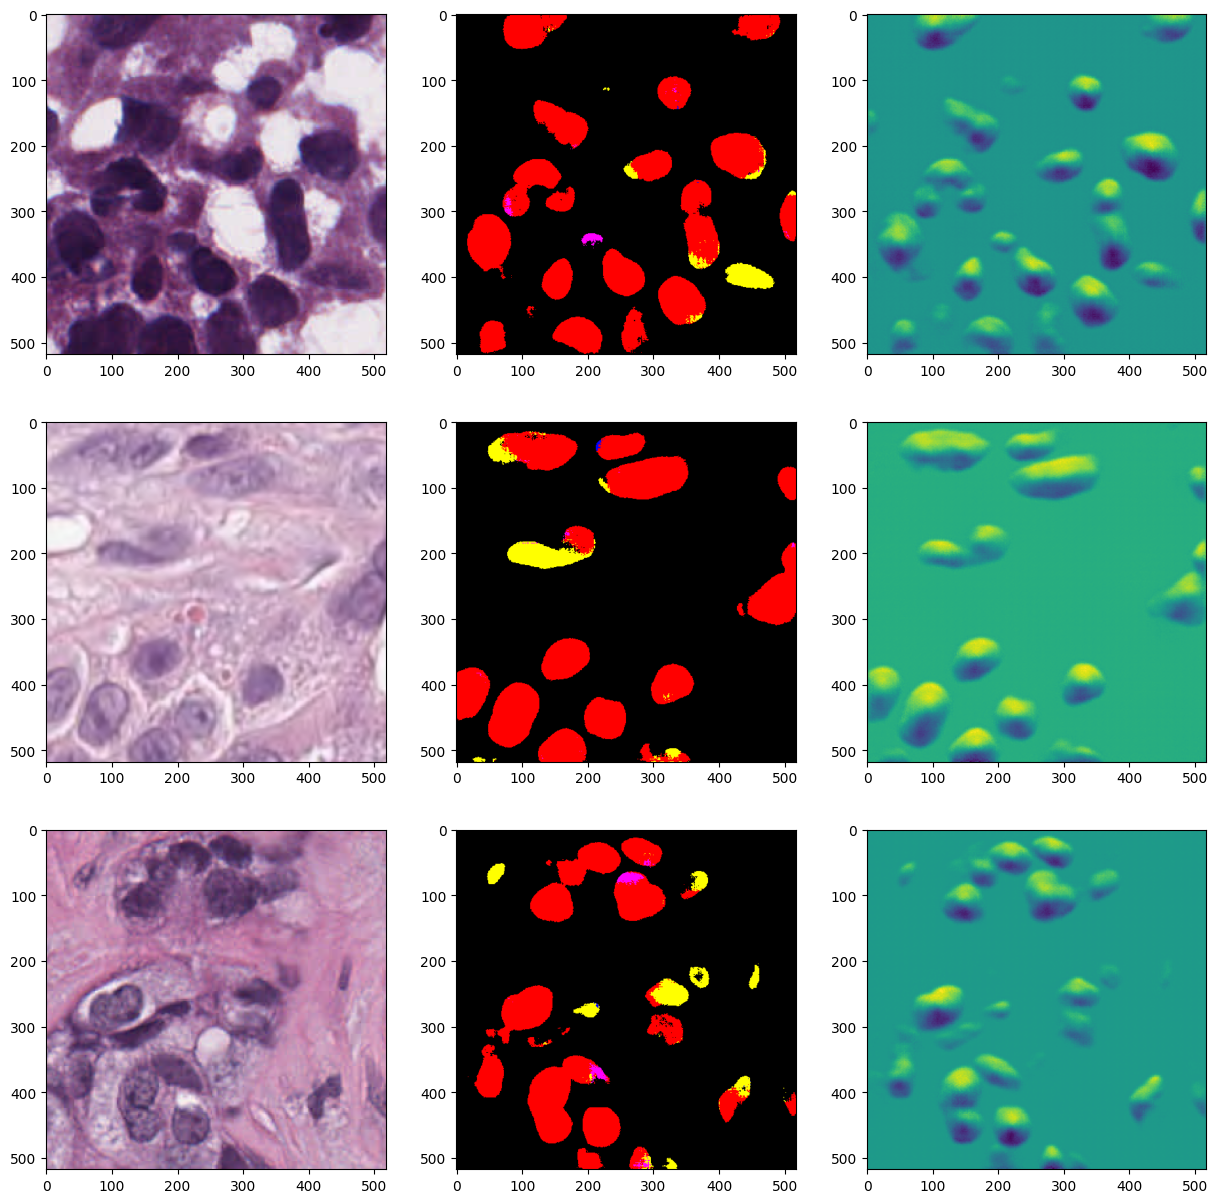

In [14]:
import torch.nn.functional as F
from cellseg_models_pytorch.utils import percentile_normalize_torch


img_dir = save_dir / "valid" / "images"
mask_dir = save_dir / "valid" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)
im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
img1 = F.interpolate(torch.from_numpy(im1).permute(2, 0, 1).unsqueeze(0), size=518)
img2 = F.interpolate(torch.from_numpy(im2).permute(2, 0, 1).unsqueeze(0), size=518)
img3 = F.interpolate(torch.from_numpy(im3).permute(2, 0, 1).unsqueeze(0), size=518)

pred1 = experiment(percentile_normalize_torch(img1.float()))
pred2 = experiment(percentile_normalize_torch(img2.float()))
pred3 = experiment(percentile_normalize_torch(img3.float()))

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(img1.cpu()[0].permute(1, 2, 0))
ax[1].imshow(
    label2rgb(np.argmax(pred1["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[2].imshow(pred1["cellpose"].squeeze().detach().numpy()[0])
ax[3].imshow(img2.cpu()[0].permute(1, 2, 0))
ax[4].imshow(
    label2rgb(np.argmax(pred2["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[5].imshow(pred2["cellpose"].squeeze().detach().numpy()[0])
ax[6].imshow(img3.cpu()[0].permute(1, 2, 0))
ax[7].imshow(
    label2rgb(np.argmax(pred3["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[8].imshow(pred3["cellpose"].squeeze().detach().numpy()[0])

## Inference and Post-processing

Typically, encoder-decoder based nuclei segmentation model outputs require post-processing. The main-task of the post-processing is to separate clumped nuclear-objects which is a renowned problem in nuclei segmentation. With `cellseg_models.pytorch`, inference and post-processing can be executed with specific `Inferer` classes that can be found in the `cellseg_models_pytorch.inference` module. 

Since the Pannuke-dataset has only 256x256px images, we can use the `ResizeInferer` to run the inference and post-processing. The `Inferer`s take in an input directory and a set of arguments, from which, the `instance_postproc` is the most important since it sets the post-processing method to be used. Here, we will use `cellpose` post-processing.

Other important params include: 
- `out_activations` - Sets the output activation functions for each of the model outputs
- `out_boundary_weights` - Sets whether we will use a weight matrix to add less weight to boundaries of the predictions. This can only be useful when inference is run for bigger images that are patched in overlapping patches (inference with overlapping patches can be done with the `SlidingWindowInferer`).
- `normalization` - Should be set to the same one as during training.
- `n_images` - Run inference only for the 50 first images of inside the input folder.

In [16]:
from cellseg_models_pytorch.inference import ResizeInferer

inferer = ResizeInferer(
    model=model,
    input_path=save_dir / "valid" / "images",
    out_activations={"cellpose": None, "type": "softmax"},
    out_boundary_weights={"cellpose": False, "type": False},
    resize=(518, 518),  # resize the input images to a multiple of 14,
    instance_postproc="cellpose",
    batch_size=8,
    n_images=50,  # Use only the 50 first images of the folder
    normalization="percentile",
    checkpoint_path=trainer.checkpoint_callback.best_model_path,
)
inferer.infer()

Running inference: 100%|██████████| 7/7 [00:05<00:00,  1.30batch/s, post-processing]


**Let's plot some results**

With only 5 epochs of training, we can get moderate results by just eyeballing. 

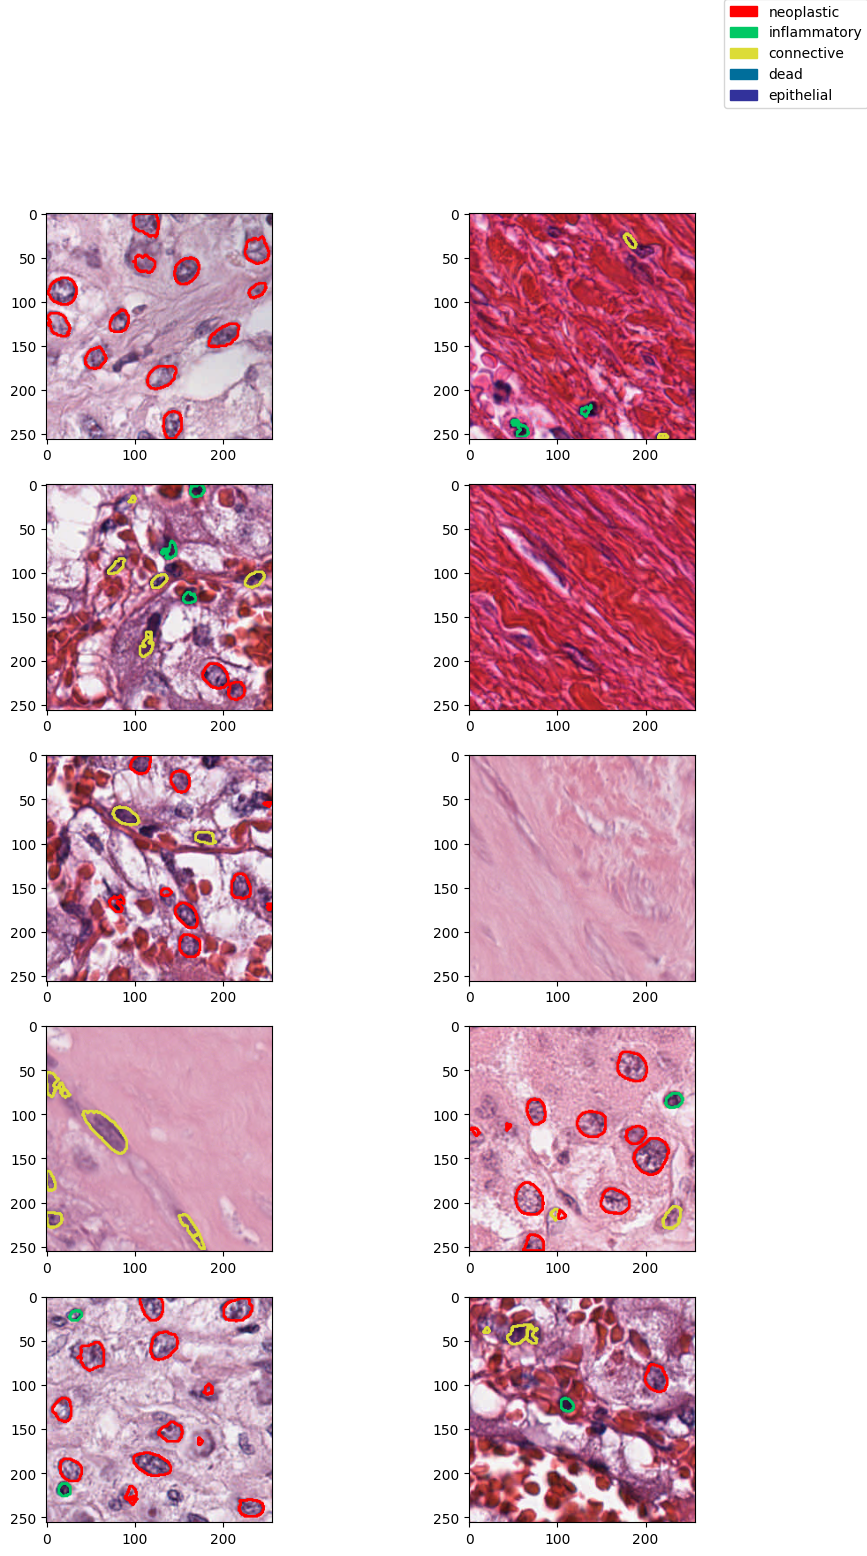

In [20]:
import numpy as np
from cellseg_models_pytorch.utils import draw_thing_contours
import matplotlib.patches as mpatches


fig, ax = plt.subplots(5, 2, figsize=(10, 17))
ax = ax.flatten()
ixs = np.random.choice(50, 10, replace=False)

samples = list(inferer.out_masks.keys())
for i, ix in enumerate(ixs):
    masks = inferer.out_masks[samples[ix]]

    img_path = save_dir / "valid" / f"images/{samples[ix]}.png"
    img = FileHandler.read_img(img_path)
    cont = draw_thing_contours(masks["inst"], img, masks["type"])
    ax[i].imshow(cont)

# add legend
cmap = {
    1: (255.0 / 255, 0.0, 0.0),
    2: (0.0, 200.0 / 255, 100.0 / 255),
    3: (220.0 / 255, 220.0 / 255, 55.0 / 255),
    4: (0.0, 110.0 / 255, 155.0 / 255),
    5: (50.0 / 255, 50.0 / 255, 155.0 / 255),
}
labels = {k: j for j, k in pannuke_module.type_classes.items()}
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
fig.legend(handles=patches, loc=1, borderaxespad=0)